## Chapter 10, Example 3c (Sparse)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Set random seed for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

# Create a figures directory if it doesn't exist
if not os.path.isdir('figures'):
    os.makedirs('figures')

# Parameters
n_hidden = 900
batch_size = 128
n_epochs = 50
learning_rate = 0.1

In [ ]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

## Defining the Autoencoder Class

In the code provided, we are defining a simple autoencoder using PyTorch. Here's a breakdown of its structure and functionality:

### Class Initialization

- The `Autoencoder` class inherits from `nn.Module`, which is a standard practice when defining any neural network model in PyTorch.

- Within the `__init__` method, we define the architecture of our autoencoder. It consists of two main parts: the encoder and the decoder.

    - `self.encoder`: This is a linear layer that reduces the dimensionality of the input data, compressing it into a lower-dimensional space. The layer's size is defined by `n_input` (the size of the input data) and `n_hidden` (the size of the compressed representation).
    
    - `self.decoder`: Another linear layer that reconstructs the original data from its compressed form. The layer's size is the reverse of the encoder, defined by `n_hidden` and `n_input`, respectively.

- The weights of the neural network are initialized following a specific strategy:

    - For the encoder, we initialize the weights with a normal distribution with a mean of `0.0` and a standard deviation of `1 / np.sqrt(n_input)`. This specific choice helps in stabilizing the learning process by controlling the variance of the weights.
    
    - For the decoder, we are using a technique called "tied weights," where the decoder's weights are the transpose of the encoder's weights (`self.encoder.weight.data.T`). This not only reduces the number of parameters in the model but also imposes a form of regularization.

### Forward Pass

- The `forward` method defines the sequence of operations the model performs to generate an output from an input.

    - The input data `x` is first passed through the encoder, compressed, and then the sigmoid activation function is applied. The sigmoid function ensures the output is in the range (0, 1), making the model's behavior more predictable and the learning process more stable.
    
    - The compressed data is then passed through the decoder, attempting to reconstruct the original input. Again, the sigmoid activation function is applied to the output.

- The final output is the activation and the reconstructed data.

### Model Instantiation

- Finally, we create an instance of the `Autoencoder` class with `28*28` input size (typical for MNIST images, which are 28x28 pixels) and `n_hidden` representing the size of our hidden (compressed) layer. This instance `model` is what we will train and use for encoding/decoding tasks.


In [ ]:
# Model
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Linear function
        self.encoder = nn.Linear(n_input, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_input)

        # Weight initialization
        self.encoder.weight.data.normal_(0.0, 1 / np.sqrt(n_input))
        self.decoder.weight.data = self.encoder.weight.data.T  # tied weights

    def forward(self, x):
        h = torch.sigmoid(self.encoder(x))
        x = torch.sigmoid(self.decoder(h))
        return h,x

model = Autoencoder(28*28, n_hidden)

## Defining the Custom Loss Function

The provided code defines a custom loss function for an autoencoder that incorporates both Mean Squared Error (MSE) and sparsity constraints using Kullback-Leibler (KL) divergence. Here's a detailed breakdown:

### Parameters:

- `h`: The activations from the hidden layer of the autoencoder.
- `y`: The reconstructed output from the autoencoder.
- `original`: The original input data to the autoencoder.

### Mean Squared Error (MSE) Loss:

- The MSE loss measures the difference between the reconstructed output `y` and the original input `original`.
- `F.mse_loss(y, original, reduction='sum')` computes the sum of squared differences between the two tensors.
- The result is normalized by the batch size `y.shape[0]` to get the average loss per data point in the batch.

### Sparsity Loss:

- The goal of the sparsity loss is to ensure that the activations in the hidden layer `h` are sparse, meaning most of the activations are close to zero.
- The desired average activation level is set to `rho`, which is typically a small value (e.g., 0.05).
- `sparsity_target` is a tensor filled with the value of `rho` and has the same size as the hidden layer.
- `sparsity_real` calculates the mean activation level across the batch for each neuron in the hidden layer.
- KL divergence, `F.kl_div(sparsity_target, sparsity_real, reduction='batchmean')`, measures the difference between the desired (`sparsity_target`) and actual (`sparsity_real`) activation distributions. It provides a measure of how much the real activations deviate from the desired level of sparsity.
- The result of the KL divergence for each neuron is summed up to get the total sparsity loss `sparse_loss`.

### Total Loss:

- The final loss is a combination of the MSE loss and the sparsity loss.
- The sparsity loss is scaled by a factor of 0.5 (or any other desired value) to control its contribution relative to the MSE loss.
- The combined loss ensures that the autoencoder not only reconstructs the input data accurately but also maintains a sparse representation in the hidden layer.


In [ ]:
def loss_function(h, y, original):
    rho = 0.05

    # Calculate the mean squared error (MSE) loss
    mse_loss = torch.mean(torch.sum((original - y) ** 2, dim=1))

    # Calculate the sparse loss
    mean_h = torch.mean(h, dim=0)
    sparse_loss = torch.sum(rho * torch.log(rho / mean_h) + (1 - rho) * torch.log((1 - rho) / (1 - mean_h)))

    return mse_loss, sparse_loss, mse_loss + 0.5 * sparse_loss

In [ ]:
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training
loss_values = []
for epoch in range(n_epochs):
    model.train()
    train_mselosses = []
    train_sparselosses = []
    train_losses = []
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)  # flatten

        # Forward pass
        activation, output = model(img)
        mseloss, sparseloss, loss = loss_function(activation, output, img)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mselosses.append(mseloss.item())
        train_sparselosses.append(sparseloss.item())
        train_losses.append(loss.item())
    avg_mseloss = np.mean(train_mselosses)
    avg_sparseloss = np.mean(train_sparselosses)
    avg_loss = np.mean(train_losses)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{n_epochs}], MSE Loss: {avg_mseloss:.4f}, Sparse Loss: {avg_sparseloss:.4f} , Total Loss: {avg_loss:.4f}')

Epoch [1/50], MSE Loss: 37.8397, Sparse Loss: 13.7096 , Total Loss: 44.6945
Epoch [2/50], MSE Loss: 20.0399, Sparse Loss: 8.0518 , Total Loss: 24.0658
Epoch [3/50], MSE Loss: 15.1569, Sparse Loss: 6.7205 , Total Loss: 18.5172
Epoch [4/50], MSE Loss: 12.6524, Sparse Loss: 5.8496 , Total Loss: 15.5772
Epoch [5/50], MSE Loss: 11.1033, Sparse Loss: 5.2567 , Total Loss: 13.7317
Epoch [6/50], MSE Loss: 10.0469, Sparse Loss: 4.8077 , Total Loss: 12.4508
Epoch [7/50], MSE Loss: 9.2714, Sparse Loss: 4.5059 , Total Loss: 11.5244
Epoch [8/50], MSE Loss: 8.6804, Sparse Loss: 4.2303 , Total Loss: 10.7956
Epoch [9/50], MSE Loss: 8.2001, Sparse Loss: 4.0304 , Total Loss: 10.2153
Epoch [10/50], MSE Loss: 7.8117, Sparse Loss: 3.8320 , Total Loss: 9.7277
Epoch [11/50], MSE Loss: 7.4748, Sparse Loss: 3.7187 , Total Loss: 9.3341
Epoch [12/50], MSE Loss: 7.1942, Sparse Loss: 3.5663 , Total Loss: 8.9773
Epoch [13/50], MSE Loss: 6.9428, Sparse Loss: 3.4675 , Total Loss: 8.6766
Epoch [14/50], MSE Loss: 6.7247

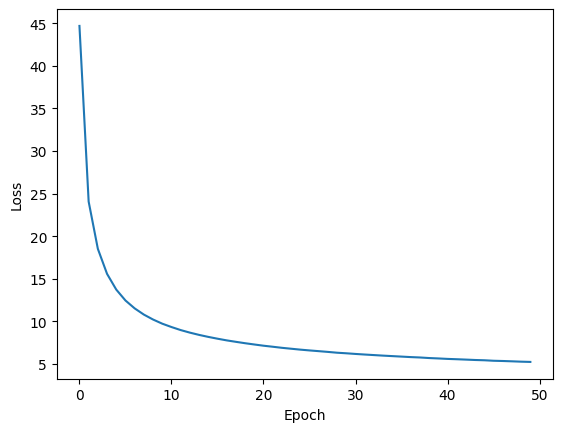

In [13]:
# Plotting the training loss
plt.figure()
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/10.3c_1.png')

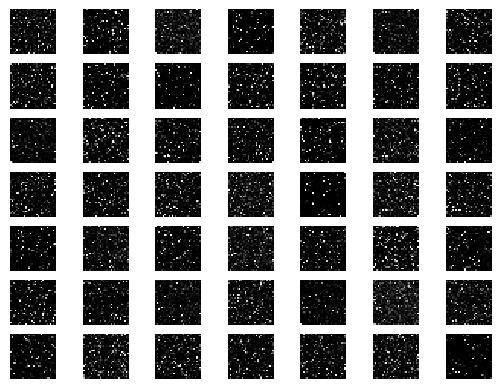

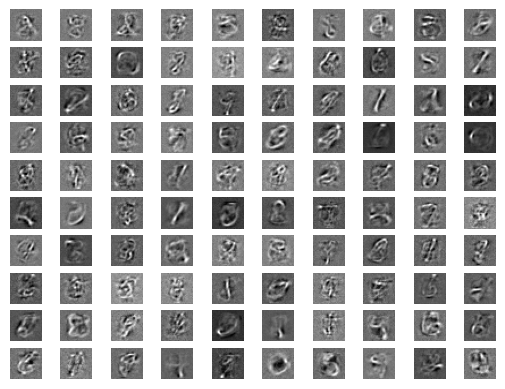

In [14]:
# Visualization
def visualize_output(images, epoch):
    # Plot original images, noisy images, and the reconstructions from the autoencoder
    model.eval()
    with torch.no_grad():
        images_flat = images.view(images.size(0), -1)
        activations, outputs = model(images_flat)
        outputs.clamp_(0, 1)  # Values might be outside [0, 1] range, clamp to ensure valid pixel range
        outputs = outputs.view(outputs.size(0), 1, 28, 28)

        # Create a grid of images including original and reconstructed images
        images = images.cpu()
        outputs = outputs.cpu()

        # Display original images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.3c_3.png')

        # Display reconstructed images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(outputs[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.3c_4.png')

        # Display hidden activations
        for i, activation in enumerate(activations[:49]):
            plt.subplot(7, 7, i+1)

            # Here, each activation is a vector. We can reshape it as a sqrt(n_hidden) x sqrt(n_hidden) image
            # if n_hidden is a perfect square. Otherwise, we could just display it as a linear array.
            act_image = activation.reshape(int(np.sqrt(n_hidden)), int(np.sqrt(n_hidden)))
            plt.imshow(act_image.cpu(), cmap='gray', interpolation='none')
            plt.axis('off')
        plt.savefig('./figures/10.3c_5.png')

# Testing with the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
test_images, _ = next(iter(test_loader))
visualize_output(test_images, n_epochs)

# Weights visualization
weights = model.encoder.weight.data.view(n_hidden, 28, 28).cpu()
plt.figure()
for i in range(100):  # displaying 100 weights
    plt.subplot(10, 10, i+1)
    plt.imshow(weights[i], cmap="gray")
    plt.axis('off')
plt.savefig('./figures/10.3c_2.png')
